In [1]:
import os
import pandas as pd
from collections import Counter
import numpy as np
import random
import json
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#supernoder files:

#вариант, который считает РАЗНЫЕ типы мотивов одного и того же размера
from SuperNoder_diff_types.manager import Manager as Manager_types 

#вариант, который считает все мотивы одного размера вместе
from SuperNoder.manager import Manager as Manager

#!pip install ipyparallel

# you should "ipcluster start -n 4" on your local machine
**instead of 4 you should write the number of engines on your computer**

In [2]:
import ipyparallel as ipp
c = ipp.Client()
dview = c[:]

**Запустите или клетку ниже, чтоб загрузить и отфлитровать данные (дольше), или клетку ниже через одну, чтоб загрузить уже отфильтрованные данные (быстрее)**

`type(graphs) = list of tuples: [(str(name),networkx(graph))]`

In [ ]:
#reading all data
for root, dirs, files in os.walk(r"C:\Users\anpolol\Desktop\DifusionPredictionUsingMotifs\Data\reply_networks"):
    datasets_names = files


to_train = ['badtattoos.json', 'gonewildcurvy.json','southpark.json','HogwartsRP.json','redditblack.json','geology.json','hardwareswap.json','counterstrike.json','stopsmoking.json','memes.json','Feminism.json','introvert.json','Pizza.json','vegetarian.json','depression.json','CrazyIdeas.json','lifehacks.json','conservatives.json','90daysgoal.json','csshelp.json','freedonuts.json','altgonewild.json','Bonsai.json','Colorado.json','GreenBayPackers.json','beertrade.json']
   
#in every graph there are 11 networks, all_nets consists of all nets  
nets_to_train=dict()
for dataset in to_train:
    if dataset not in nets_to_train:
        nets_to_train[dataset] = []
        month_nets = json.load(open(r"C:\Users\anpolol\Desktop\DifusionPredictionUsingMotifs\Data\reply_networks\\"+str(dataset)))
        nets_to_train[dataset]=nets_to_train[dataset] + month_nets

#фильтрация по размеру исходных графов
def func(inp):
        from collections import Counter
        import networkx as nx
        dataset,values = inp
        name = dataset.split('.')
        graphs=[]
        for i,net in enumerate(values):

            t=list(net.values()) #extracting nodes from json files
            nodes = (Counter([item for sublist in t for item in sublist] + list(net.keys())))

            map_nodes=dict(zip(nodes, list(range(len(nodes))))) #нумеруем ники

            g = nx.Graph()
            for node in range(len(nodes)):
                g.add_node(node,label='Motif')

            for node in net:
                for neigh in net[node]:
                    g.add_edge((map_nodes[node]),(map_nodes[neigh])) #first node replied to the second   
                    
            for j,k in enumerate(nx.connected_components(g)):
                if j==0:
                    g_new = g.subgraph(k)
                    old_ind = sorted(g_new)
                    new_ind = list(range(len(old_ind)))
                    mapping = dict(zip(old_ind,new_ind))
                    g_new = nx.relabel_nodes(g_new, mapping)
                    if g_new.number_of_nodes()>50:
                        graphs.append((name[0]+'.'+str(i)+'.'+str(j),g_new)) #i - месяц, j - номер кмпоненты связности
        return graphs
res = dview.map(func, list(nets_to_train.items())).get()

graphs=[]
for i in res:
    graphs+=i

In [6]:
#Загрузка готовых данных
with open('all_graph.pickle','rb') as f:
    graphs=pickle.load(f)

**Характеристика отфильтрованных графов**
- число узлов 
- плотность
- к-т кластеризации (общий, для графа)
- ассортативность (по степени)

In [ ]:
#конвертируем список кортежей в словарь для более быстрого счета
new_names = list(map(lambda x: x.split('.')[0], list(zip(*graphs))[0]))
new_graphs = list(zip(new_names, list(zip(*graphs))[1]))

graphs_dict=dict()
for name,g in new_graphs:
    if name not in graphs_dict:
        graphs_dict[name]=[]
    graphs_dict[name].append(g)

In [ ]:
# Характеристика графов по темам
table_names=[]
table_NN_mean=[]
table_CC_mean=[]
table_D_mean=[]
table_DAC_mean=[]

table_NN_std=[]
table_CC_std=[]
table_D_std=[]
table_DAC_std=[]


for k in graphs_dict:
    number_of_nodes = []
    clustering_coef=[]
    density=[]
    degree_assort=[]
    graphs=[]

    table_names.append(k)
    
    for gr in graphs_dict[k]:
            #число узлов 
            number_of_nodes.append(gr.number_of_nodes())
            #коэффициенты кластеризации ищутся следующим образом:
            clustering_coef.append(np.mean(list(nx.clustering(gr).values())))
            #плотность
            density.append(nx.density(gr))
            #ассортативность
            degree_assort.append(nx.degree_assortativity_coefficient(gr))
    table_NN_mean.append(np.mean(np.array(number_of_nodes)))
    table_CC_mean.append(np.mean(np.array(clustering_coef)))
    table_D_mean.append(np.mean(np.array(density)))
    table_DAC_mean.append(np.mean(np.array(degree_assort)))
    table_NN_std.append(np.std(np.array(number_of_nodes)))
    table_CC_std.append(np.std(np.array(clustering_coef)))
    table_D_std.append(np.std(np.array(density)))
    table_DAC_std.append(np.std(np.array(degree_assort)))

In [ ]:
mean_df = pd.DataFrame({'Name of dataset' : table_names,
                                'Number of nodes (NN)' :table_NN_mean,
                                'Clustering coefficient (CC)': table_CC_mean,'Density(D)':table_D_mean, 'Degree assortativity coefficient(DAC)':table_DAC_mean})
std_df = pd.DataFrame({'Name of dataset' : table_names,
                                'Number of nodes (NN)' :table_NN_std,
                                'Clustering coefficient (CC)': table_CC_std,'Density(D)':table_D_std, 'Degree assortativity coefficient(DAC)':table_DAC_std})

# **Motif counter - SuperNoder** 

**arguments for SuperNoder:**

-n,  --nodes-file <filename> MANDATORY The list of nodes. Node id and label for each row separated by a space\
-e,  --edges-file <filename> MANDATORY The list of edges. One edge for each row.\
-m,  --method <method> OPTIONAL The heuristic to use in order to maximize motifs. DEFAULT: h1 \
-tn, --type-of-network <type> OPTIONAL 	The type of network. It can be chosen from [direct, undirect]. DEFAULT: undirect\ 
-th, --threshold <threshold> OPTIONAL The threshold to hold over-represented motifs.\
-ms, --motif-size <size> OPTIONAL The size of motifs. It must be greater or equal to 3. DEFAULT: 3\
-h1tr, --h1-times-repetition <times> OPTIONAL \tThe number of repetition of h1. DEFAULT: 1\
-ss, --samples-size <sample_size> OPTIONAL The size of samples for heuristics h4 and h5. DEFAULT: 100\

In [ ]:
# here is a parallelization
res = dview.map(find_disjoint_motifs,graphs[:2]).get()

In [ ]:
#distributions of motifs for every net:
Motif_f1 = dict()
Motif_f3 = dict()
for (name,f3,f1) in res:
    Motif_f3[name] = f3
    Motif_f1[name] = f1

**составляем матрицу входных данных таким образом, чтоб она была одной и той же длины для любого датасета**

In [ ]:
names_of_all_motifs=[] #list of all motif types in all datasets
for dataset in Motif_f3:
    for name_of_motif in Motif_f3[dataset]:
        if name_of_motif not in names_of_all_motifs:
            names_of_all_motifs.append(str(name_of_motif))
names_of_all_motifs=sorted(names_of_all_motifs)

In [ ]:
X = np.zeros((len(args_e),len(names_of_all_motifs)))
for i,d in enumerate(args_e):
    for k,m in enumerate(names_of_all_motifs):
        if m in Motif_f3[d]:
            X[i][k] = Motif_f3[d][m]/sum(Motif_f3[d].values())  

# Sampling

In [3]:
from littleballoffur import DegreeBasedSampler,\
                               PageRankBasedSampler,\
                               RandomEdgeSampler,\
                               SnowBallSampler,\
                               ForestFireSampler,\
                               CommunityStructureExpansionSampler,\
                               ShortestPathSampler,\
                               RandomWalkSampler,\
                               RandomWalkWithJumpSampler,\
                               MetropolisHastingsRandomWalkSampler,\
                               NonBackTrackingRandomWalkSampler,\
                               CirculatedNeighborsRandomWalkSampler,\
                               CommonNeighborAwareRandomWalkSampler,\
                               LoopErasedRandomWalkSampler
methods = [
           #random node sampling
           DegreeBasedSampler,
           PageRankBasedSampler,

           #Random Edge Sampling
           #RandomEdgeSampler, ---- ошибка с label
           SnowBallSampler,
           #ForestFireSampler, ---- pop from an empty deque
           CommunityStructureExpansionSampler,
           ShortestPathSampler,
            #Random-Walks Dased
           RandomWalkSampler,
           RandomWalkWithJumpSampler,
           MetropolisHastingsRandomWalkSampler,
           NonBackTrackingRandomWalkSampler,
           CirculatedNeighborsRandomWalkSampler,
          # CommonNeighborAwareRandomWalkSampler, probabilities contain NaN
           #LoopErasedRandomWalkSampler --- label
          ]

In [9]:
#Расчёт мотивов для полный графов -- долго, в нижней клетке загрузка этих же данных из файла 
from modules.support_functions import Utils
motifs_all_graphs = dict()
for graph in graphs_to_train:
    _,motifs, motifs_disjoint = Utils.find_motifs(graph)
    motifs_all_graphs[graph[0]] = (motifs, motifs_disjoint)

In [ ]:
#загрузка мотивов для полных графов
with open('motifs_of_3_full_graphs.pickle','rb') as f:
    motifs_all_graphs=pickle.load(f)

In [8]:
graphs_to_train = random.choices(graphs,k=10) #тут я просто сократила количество графов чтоб быстрее посчиталось 
with open('graphs_to_train.pickle','wb') as f:
        pickle.dump(graphs_to_train,f)    

In [ ]:
def find_MSE(inp): #возвращает MSE для мотивов f1 И f3. Без разделения на разные типы мотивов. Размеры мотивов 3 и 4
        method,number_of_nodes = inp
        
        import pickle
        import random
        from modules.support_functions import Utils
        from sklearn.metrics import mean_squared_error
        
        with open('motifs_of_3_full_graphs.pickle','rb') as f:
            motifs_all_graphs=pickle.load(f)
        with open('graphs_to_train.pickle','rb') as f:
            graphs_to_train=pickle.load(f)
        
        MSE_f1 = []
        MSE_f3 = []
        
        for graph in graphs_to_train:
            if number_of_nodes<=graph[1].number_of_nodes():
                motifs, motifs_disjoint = motifs_all_graphs[graph[0]]
                arg_tn='undirect'
                arg_th = '1' 
                arg_m = 'h1'
                arg_ss = '100'
                arg_h1tr = 1 
                sampler = method(number_of_nodes)
                sample = sampler.sample(graph[1])
                _,motifs_sample, motifs_disjoint_sample = Utils.find_motifs((graph[0],sample))
                motifs_con, motifs_sample_con = Utils.motifs_to_vec(motifs,motifs_sample)
                motifs_disjoint_con, motifs_disjoint_sample_con = Utils.motifs_to_vec(motifs_disjoint,motifs_disjoint_sample)

                MSE_f1.append(mean_squared_error(motifs_con,motifs_sample_con))
                MSE_f3.append(mean_squared_error(motifs_disjoint_con,motifs_disjoint_sample_con))
            else:
                MSE_f1.append(0)
                MSE_f3.append(0)
        return number_of_nodes,MSE_f1, MSE_f3

In [16]:
methods = methods
from sklearn.metrics import mean_squared_error 
from datetime import datetime
MSE_methods_f1=dict()
MSE_methods_f3=dict()

for method in methods[:5]:
    d = datetime.now()
    MSE_methods_f1[str(method).split('.')[3]] = dict()
    MSE_methods_f3[str(method).split('.')[3]] = dict()
    # here is a parallelization
    inp = zip([method]*9,list(range(10,100,10)))
    res = dview.map(find_MSE,inp).get()
    for number_of_nodes,MSE_f1,MSE_f3 in res: 
        MSE_methods_f1[str(method).split('.')[3]][str(number_of_nodes)]=MSE_f1
        MSE_methods_f3[str(method).split('.')[3]][str(number_of_nodes)]=MSE_f3
    print(datetime.now()-d)

In [44]:
def plot(MSE_dict, name_of_method): 
    MSE = pd.DataFrame(MSE_dict , columns = list(MSE_dict.keys()))
    plt.figure(figsize=(20,6))
    plt.suptitle(name_of_method.split("'")[0], fontsize=22)
    plt.subplot(121)
    plt.xlabel("number of nodes")
    plt.ylabel("MSE")
    g1 = sns.boxplot(data=MSE)
    g1.set_yscale('log')
    plt.subplot(122)
    plt.xlabel("number of nodes")
    plt.ylabel("MSE")
    y = list(MSE.mean())
    x = list(map(lambda x: int(x),list(MSE.columns)))
    g2 = sns.scatterplot(x = x, y=y)
    g2.set_yscale('log')

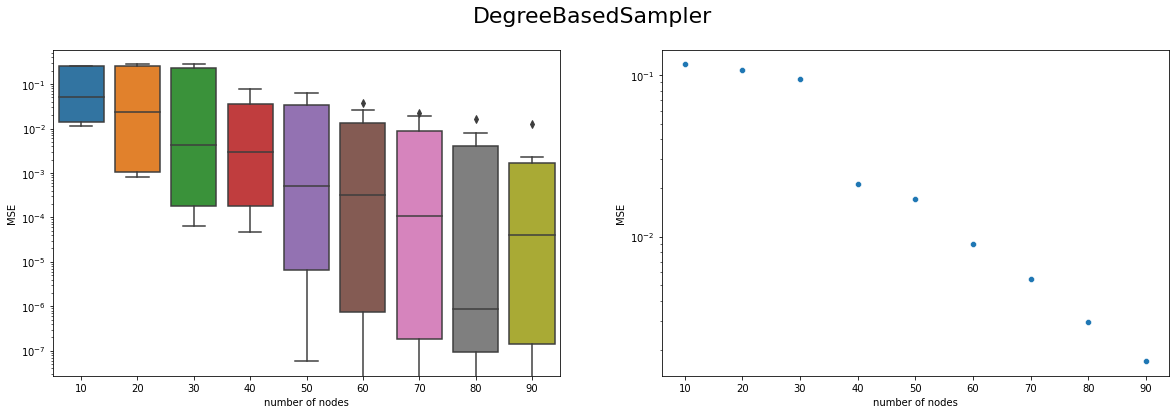

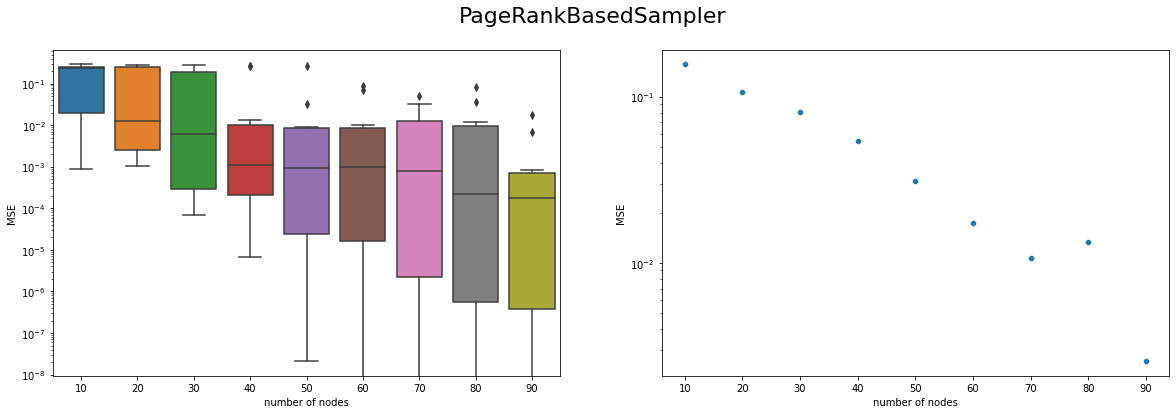

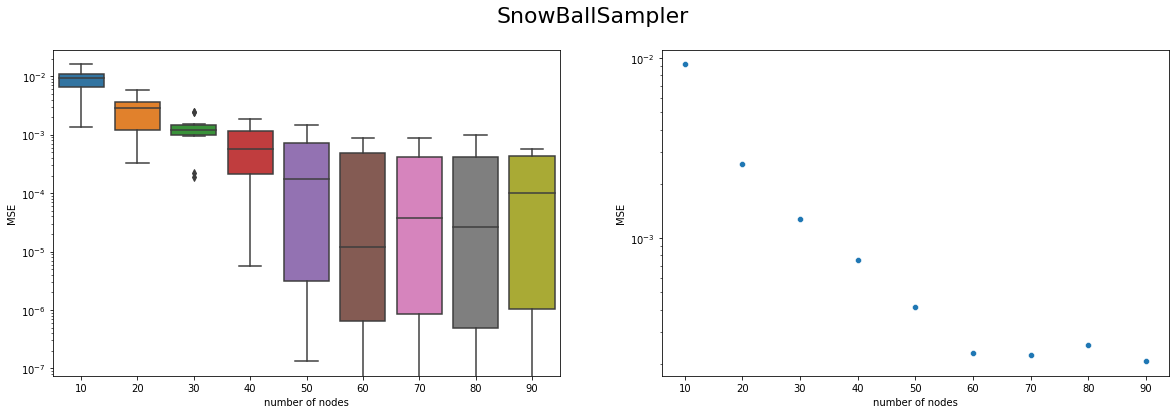

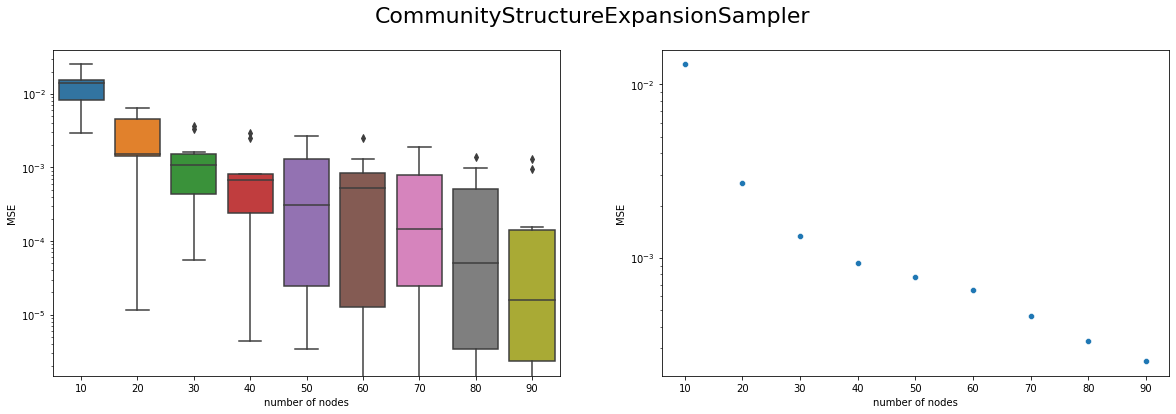

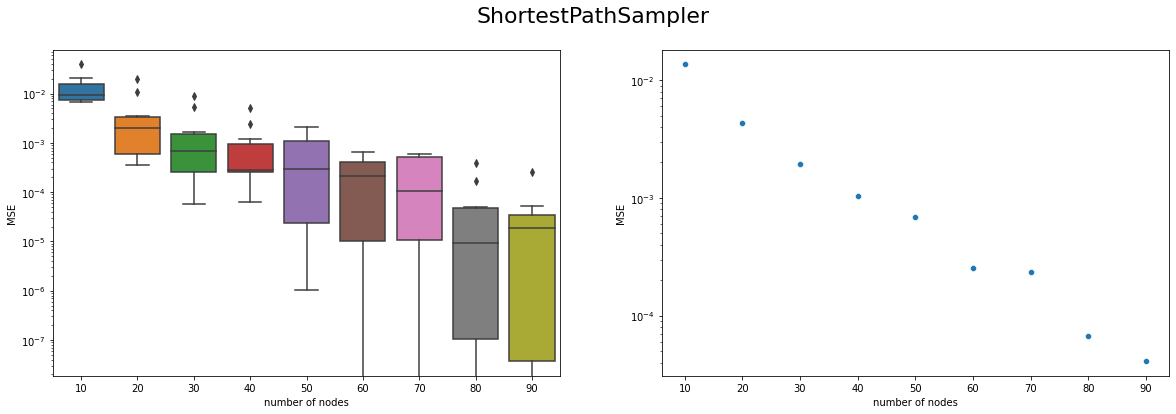

In [50]:
for name in MSE_methods_f3:
    plot(MSE_methods_f1[name],name)

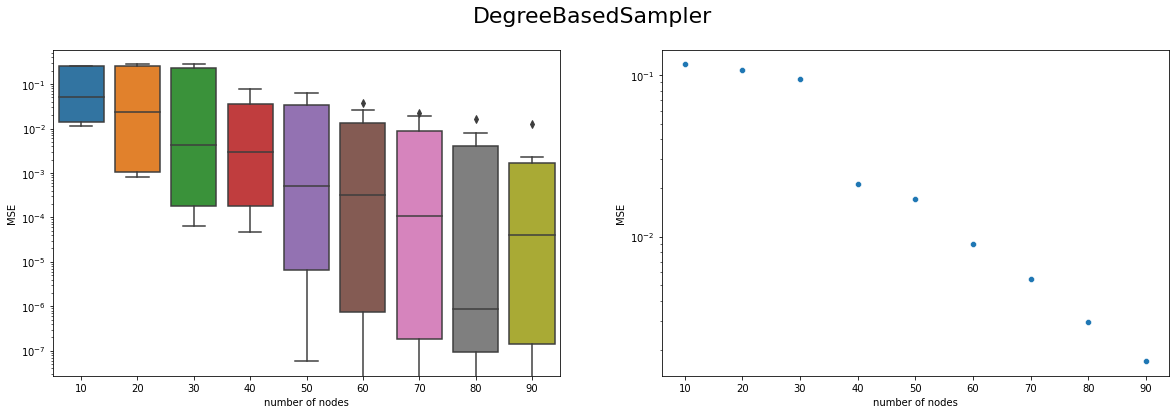

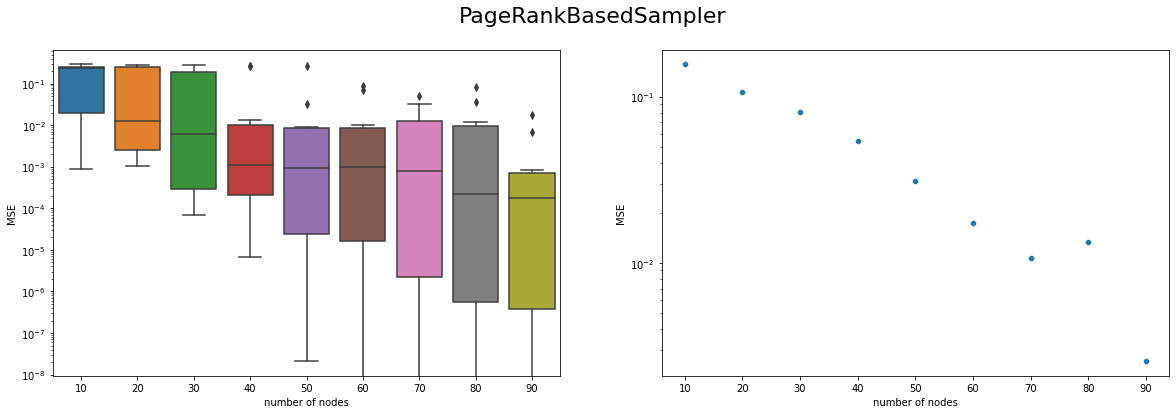

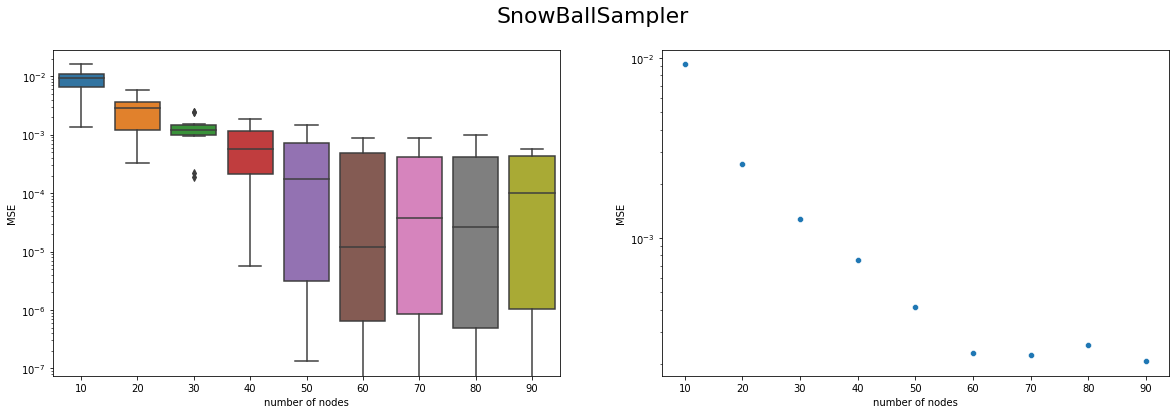

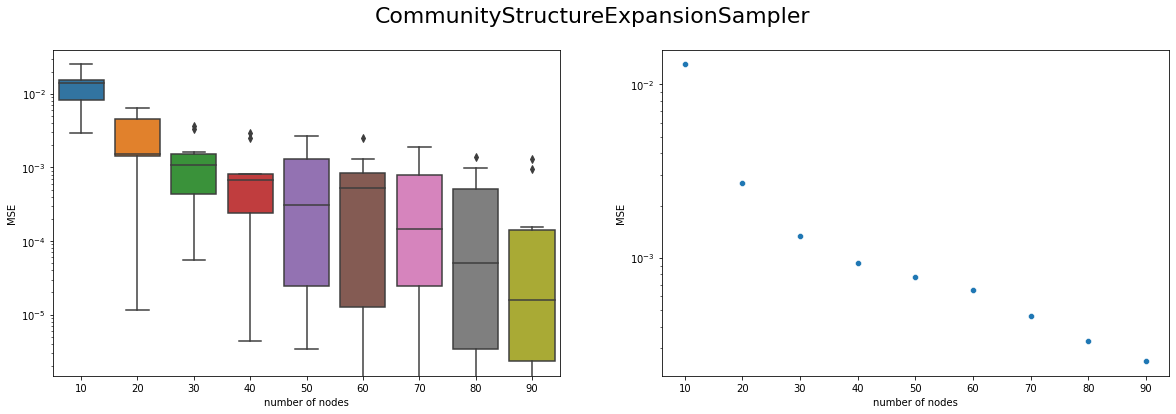

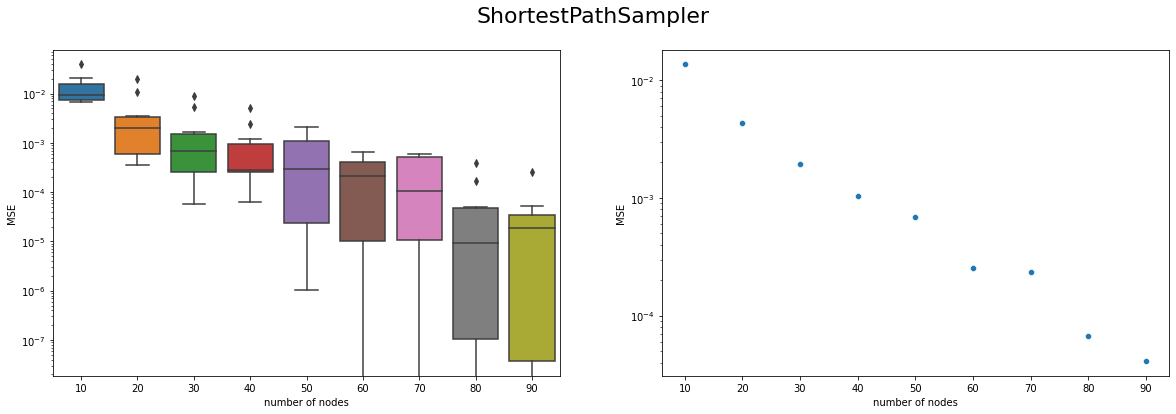

In [51]:
for name in MSE_methods_f1:
    plot(MSE_methods_f1[name],name)

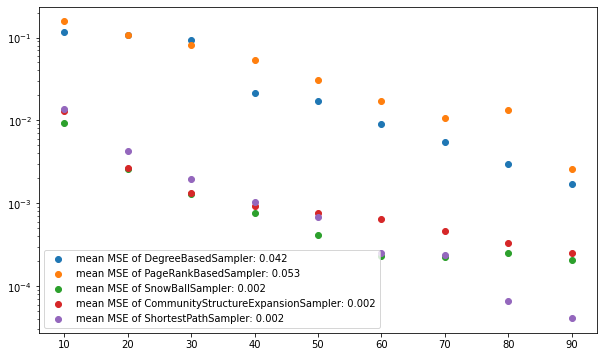

In [71]:
plt.figure(figsize=(10,6))
mean_MSEs = []
for name in MSE_methods_f1:
    MSE_dict = MSE_methods_f1[name]
    MSE = pd.DataFrame(MSE_dict , columns = list(MSE_dict.keys()))
    y = list(MSE.mean())
    x = list(map(lambda x: int(x),list(MSE.columns)))
    ax = plt.scatter(x=x, y=y)
    plt.yscale('log')
    mean_MSEs.append(sum(y)/len(y))
    
plt.legend(['mean MSE of ' + str(x[0]).split('.')[-1].split("'")[0] +': ' +str(np.round(x[1], decimals=3)) for x in zip(methods, mean_KLDs)])
plt.show()